# 기계시설물 고장 예지 센서 불량 탐지하기

In [1]:
# Basic
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

import pickle, os, glob, re, random
from tqdm import tqdm

# Model
import scipy
from scipy.special import entr
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
from tensorflow.keras import layers

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# from matplotlib import font_manager, rc
# plt.rcParams['font.family'] = 'NanumGothic'
# import platform
# if platform.system() == 'Windows':
#     font_nasme = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#     rc('font', family=font_name)
# else:    
#     rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rc('font', family='Malgun Gothic')

# Function

In [2]:
#rms calculator
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

#extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

#extract shannon entropy(cut signals to 500 bins)
def calculate_entropy(df):
    entropy = []
    for col in df:
        entropy.append(scipy.stats.entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(entropy)

#time_features extractor
def time_features(path):
    time_features = ['mean', 'std', 'skew', 'kurtosis', 'entropy', 'rms', 'max', 'p2p']
    cols = ['B1']
    
    # initialize
    columns = [c+'_'+tf for c in cols for tf in time_features]
    data = pd.DataFrame(columns = columns)
    
    for idx in tqdm(range(len(path))):
        #read dataset
        raw_data = pd.read_csv(path[idx], 
                               skiprows=9, usecols=[1], names = ['B1'])
        
        #time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        
        #make dataframe
        mean_abs = pd.DataFrame(mean_abs.reshape(1,1), columns = [c+'_mean' for c in cols])
        std = pd.DataFrame(std.reshape(1,1), columns = [c+'_std' for c in cols])
        skew = pd.DataFrame(skew.reshape(1,1), columns = [c+'_skew' for c in cols])
        kurtosis = pd.DataFrame(kurtosis.reshape(1,1), columns = [c+'_kurtosis' for c in cols])
        entropy = pd.DataFrame(entropy.reshape(1,1), columns = [c+'_entropy' for c in cols])
        rms = pd.DataFrame(rms.reshape(1,1), columns = [c+'_rms' for c in cols])
        max_abs = pd.DataFrame(max_abs.reshape(1,1), columns = [c+'_max' for c in cols])
        p2p = pd.DataFrame(p2p.reshape(1,1), columns = [c+'_p2p' for c in cols])
        
        #indexing
        time_part = ''.join(path[idx].split("_")[-3:-1])
        year = time_part[0:4]
        month = time_part[4:6]
        day = time_part[6:8]
        hour = time_part[8:10]
        minute = time_part[10:12]
        seconds = time_part[12:15]
        timename = year+'.'+month+'.'+day+'.'+hour+'.'+minute+'.'+seconds
        
        
        mean_abs.index = [timename]
        std.index = [timename]
        skew.index = [timename]
        kurtosis.index = [timename]
        entropy.index = [timename]
        rms.index = [timename]
        max_abs.index = [timename]
        p2p.index = [timename]
        
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p], axis = 1)
        data = data.append(merge)
        
        cols2 = [c+'_'+tf for c in cols for tf in time_features]
        data = data[cols2]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    data.index.name = "time"
    return data

def plot_features(df, col, name):
    df.index = pd.DatetimeIndex(df['time'])
    fig, axes = plt.subplots(len(col), 1, figsize=(20, 3*len(col)), dpi=120)
    for idx, i in enumerate(col):
        axes[idx].plot(df[i])
        axes[idx].set_title(f"{name}_{i}")
#         ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    plt.tight_layout()
    plt.show()    

# Data
기계시설물을  동작시키는  모터가  동작할  때  발생하는 고유의 진동을 수집한 데이터([데이터 출처](https://aihub.or.kr/aidata/30748))

- 모터  외부에  진동센서를  부착하여  일정  시간  단위로  모터의  떨림  정도를 측정
- 모터 동력은 3.75KW 
- Sample Rate는  기본  4kHz로 1초당 4,000개의 sample들을 측정함  
- 3초간  측정하기 때문에 하나의 csv 파일마다 총 12,000개의 데이터가 들어있음
- 센서  데이터의  오류는 총 5개로 사용할 데이터의 오류 종류는 **축정렬불량**

불량 데이터 20,000개, 정상 데이터 100,000개 중 일부 subsampling

In [3]:
filepath = "./data/AI_herb"

In [4]:
filepath_n = glob.glob(os.path.join(os.path.join(filepath, "3.75kW/R-PAC-01R"),'정상/*.csv'))
filepath_f = glob.glob(os.path.join(os.path.join(filepath, "3.75kW/R-PAC-01R"),'축정렬불량/*.csv'))
filelist_n = list(map(lambda x: os.path.basename(x), filepath_n))
filelist_f = list(map(lambda x: os.path.basename(x), filepath_f))

In [5]:
print(f"정상 데이터: {len(filelist_n)}개")
print(*filelist_n[:5], sep='\n')
print(f"\n불량 데이터: {len(filelist_f)}개")
print(*filelist_f[:5], sep='\n')

정상 데이터: 13717개
STFMK-20201105-LW19-2505_20201125_153851_004.csv
STFMK-20201105-LW19-2505_20201125_153854_004.csv
STFMK-20201105-LW19-2505_20201125_153903_004.csv
STFMK-20201105-LW19-2505_20201125_153906_004.csv
STFMK-20201105-LW19-2505_20201125_153909_004.csv

불량 데이터: 15329개
STFMK-20201105-LW19-2505_20201201_113553_004.csv
STFMK-20201105-LW19-2505_20201201_113602_004.csv
STFMK-20201105-LW19-2505_20201201_113644_004.csv
STFMK-20201105-LW19-2505_20201201_113647_004.csv
STFMK-20201105-LW19-2505_20201201_113735_004.csv


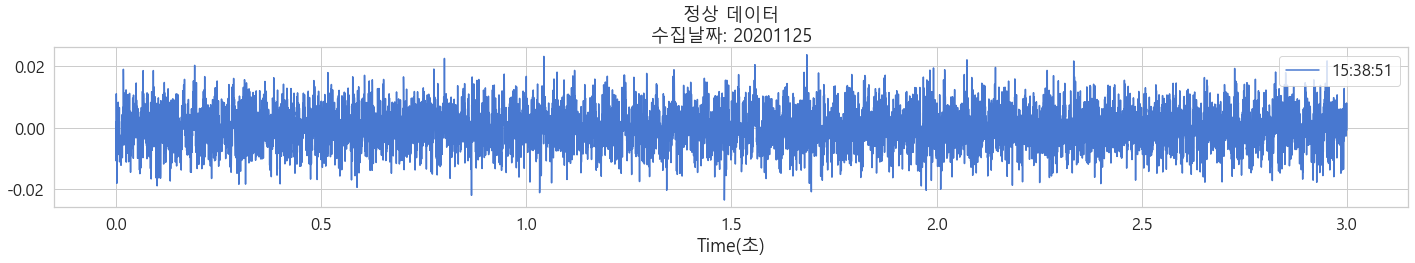

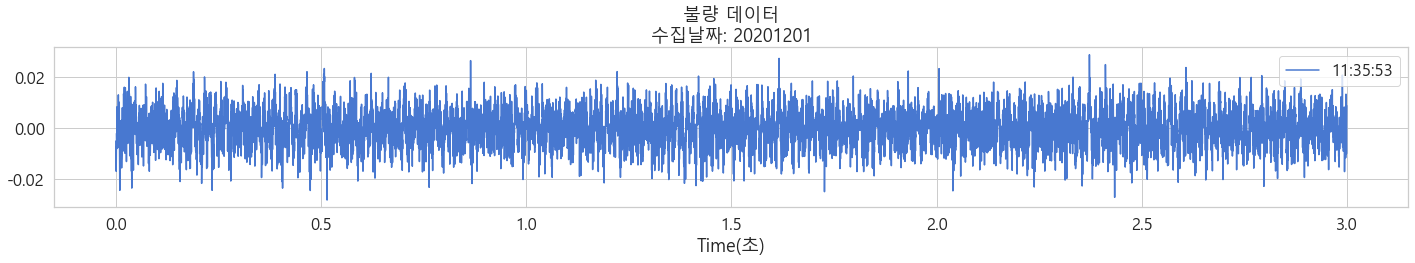

In [6]:
# 정상
fig, ax = plt.subplots(figsize=(20,4))
for idx in range(1):
    data = pd.read_csv(filepath_n[idx], skiprows=9, usecols=[0,1], names = ['time', 'value'])
    data_time = ':'.join(re.findall(r'..', filepath_n[idx].split("_")[-2] + str(2)))
    plt.plot(data.time, data.value, label=data_time)
    plt.title(f"정상 데이터\n수집날짜: {filepath_n[idx].split('_')[-3]}")
    plt.xlabel("Time(초)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 불량
fig, ax = plt.subplots(figsize=(20,4))
for idx in range(1):
    data = pd.read_csv(filepath_f[idx], skiprows=9, usecols=[0,1], names = ['time', 'value'])
    data_time = ':'.join(re.findall(r'..', filepath_f[idx].split("_")[-2] + str(2)))
    plt.plot(data.time, data.value, label=data_time)
    plt.title(f"불량 데이터\n수집날짜: {filepath_f[idx].split('_')[-3]}")
    plt.xlabel("Time(초)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [7]:
# %%time
# set_n = time_features(filepath_n)
# set_f = time_features(filepath_f)
# set_n.to_csv(os.path.join(filepath,f'set_n_all.csv'))
# set_f.to_csv(os.path.join(filepath,f'set_f_all.csv'))

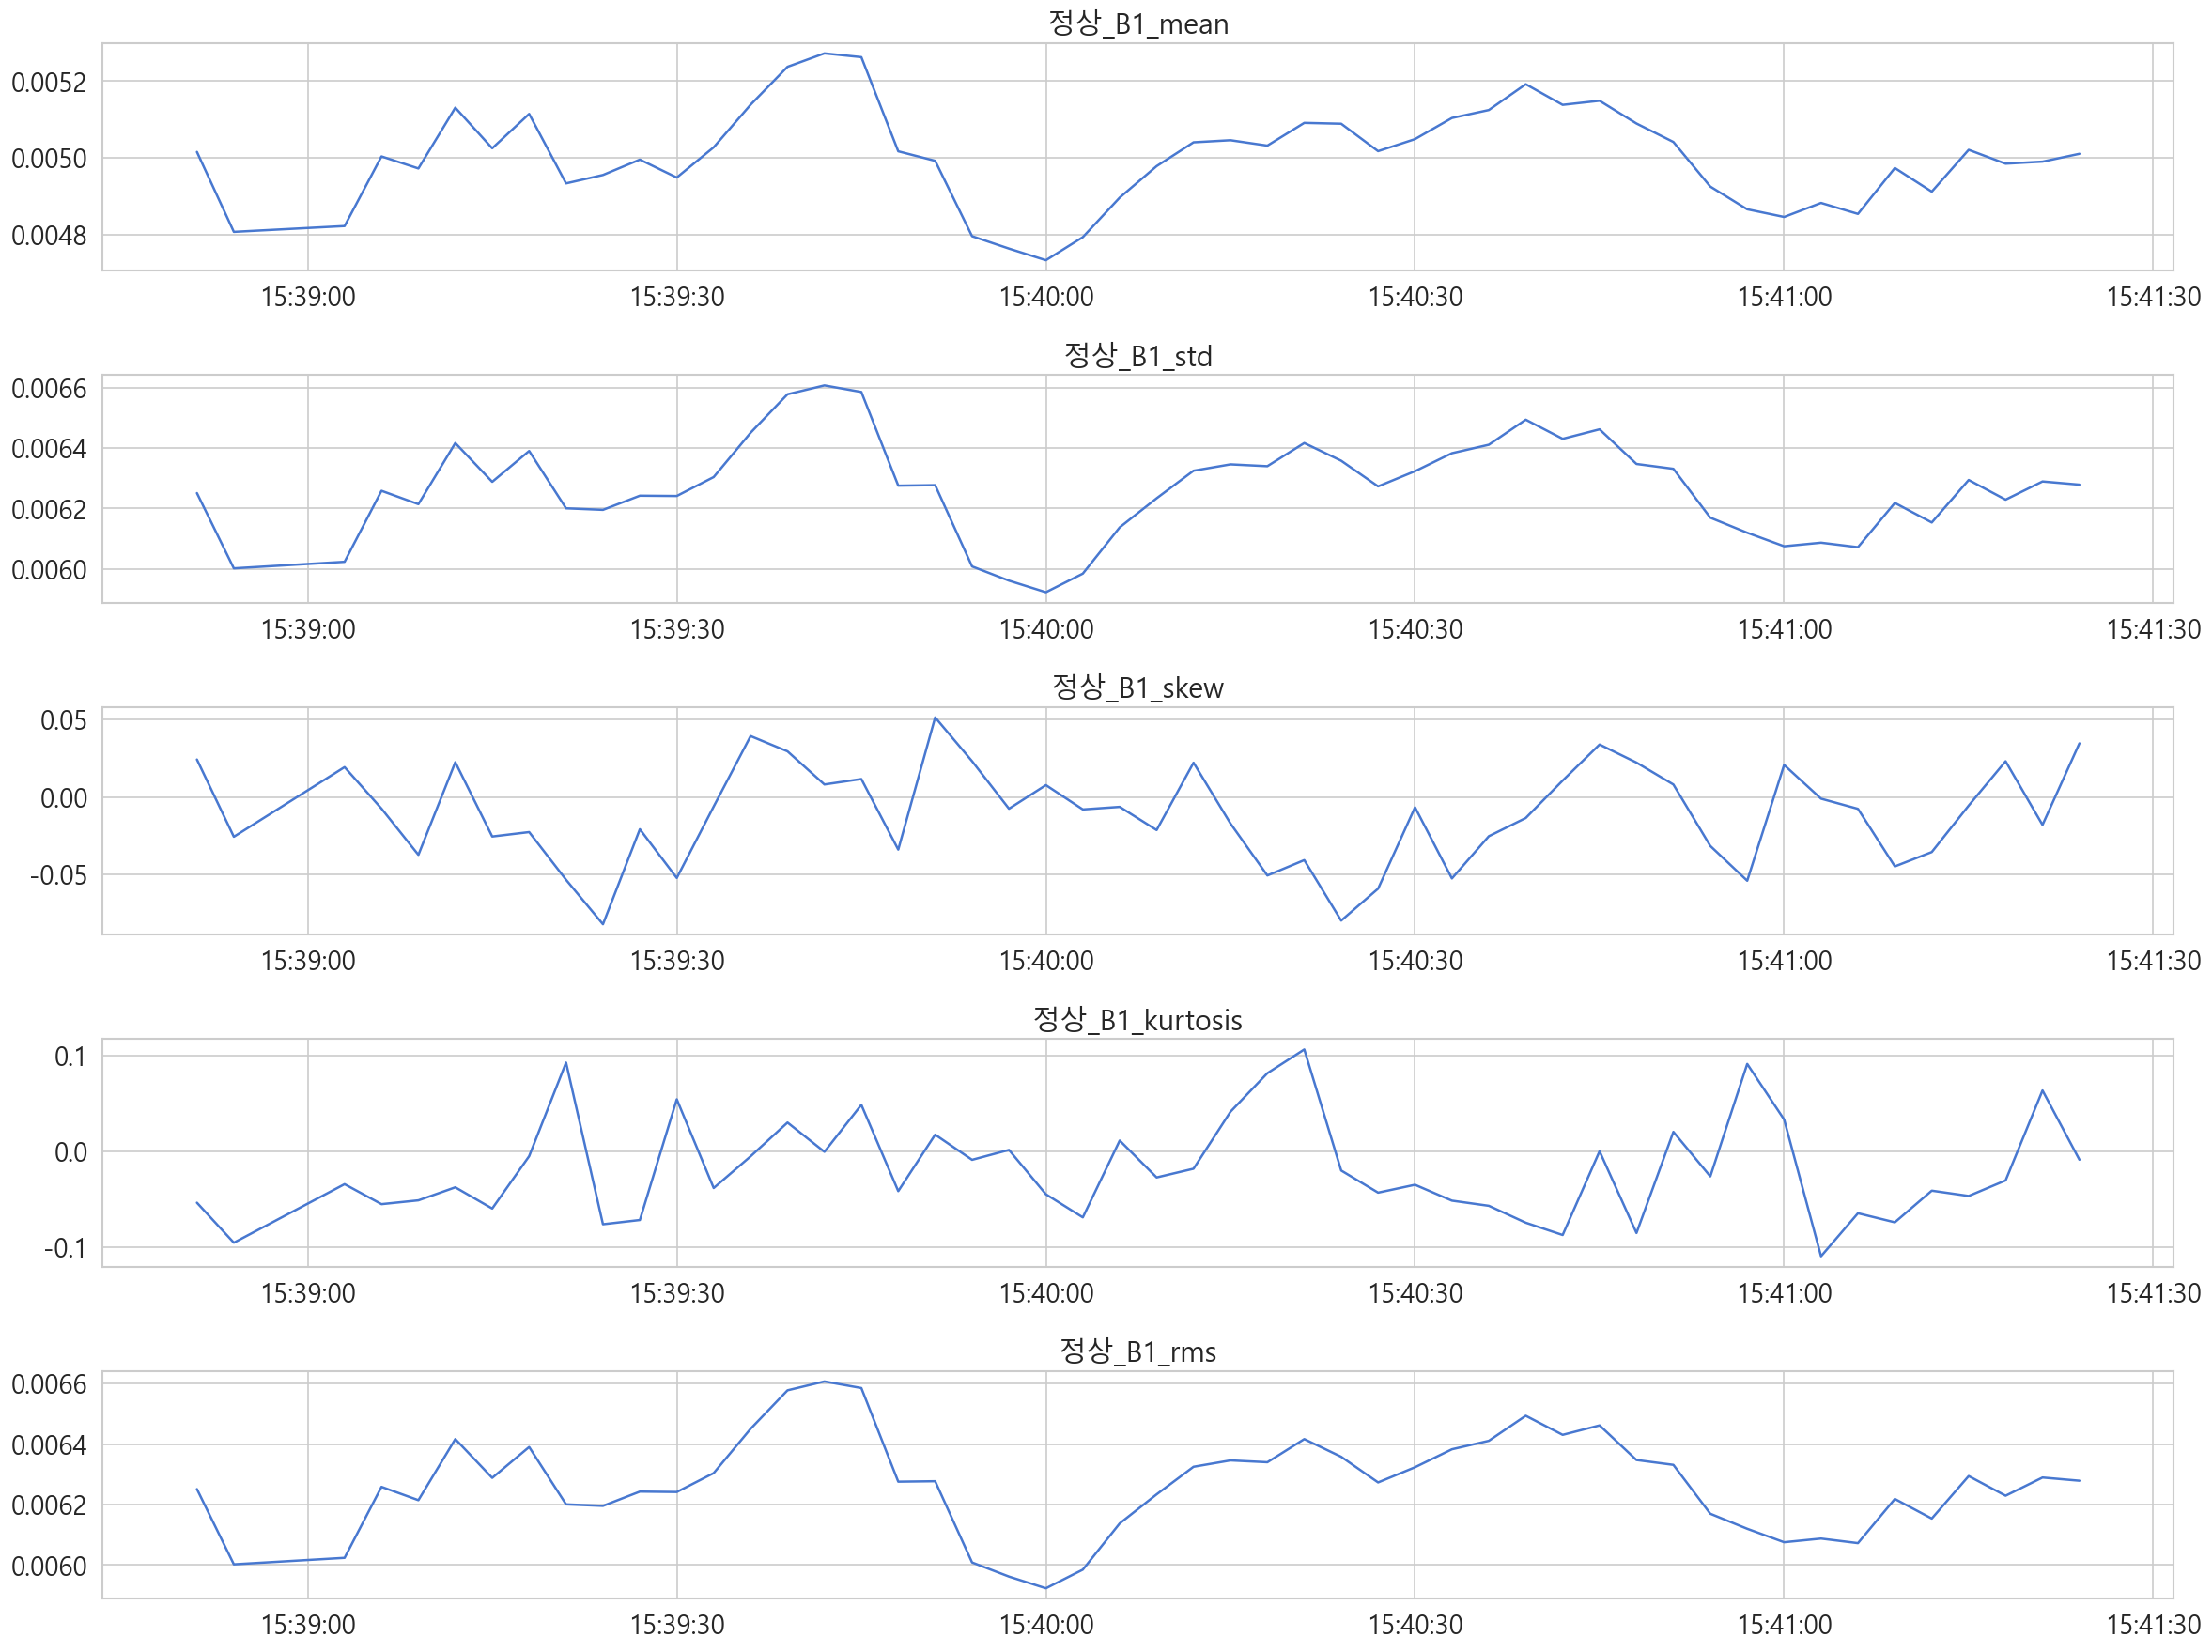

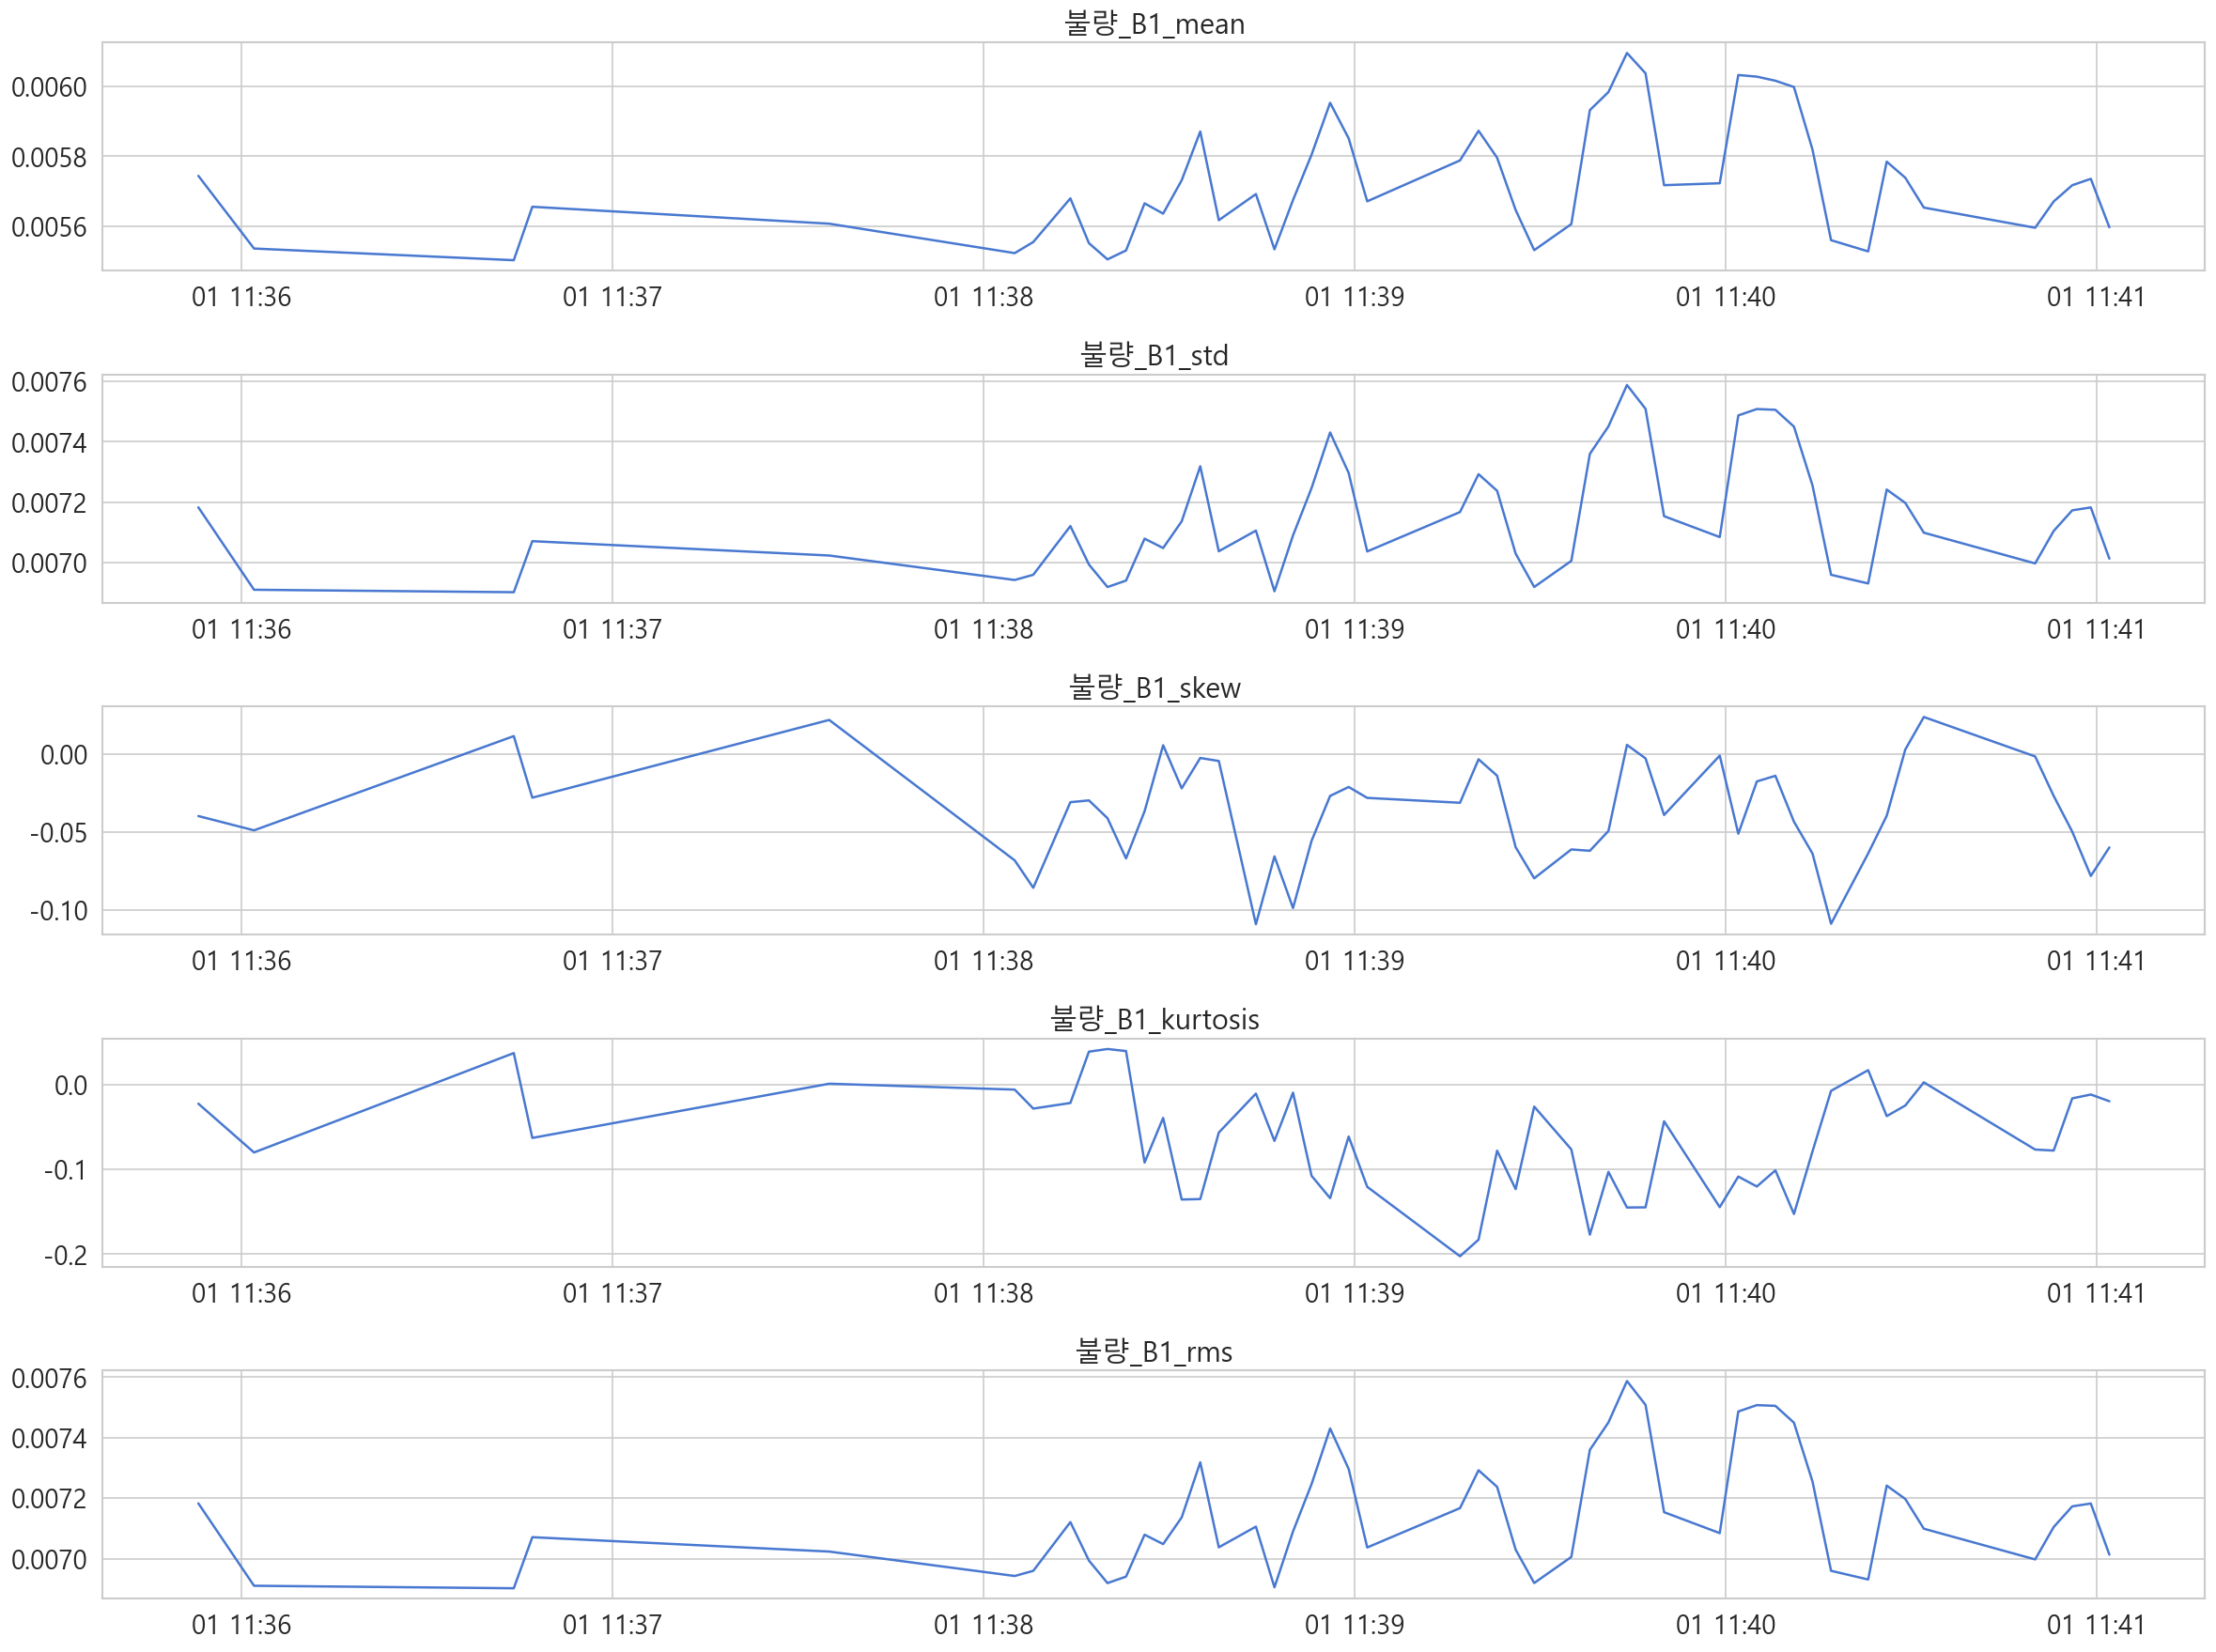

In [8]:
nsamp = 50
set_n = pd.read_csv(os.path.join(filepath,f'set_n_{nsamp}.csv'))
set_f = pd.read_csv(os.path.join(filepath,f'set_f_{nsamp}.csv'))
plot_features(set_n, ['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis','B1_rms'], "정상")
plot_features(set_f, ['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis','B1_rms'], "불량")

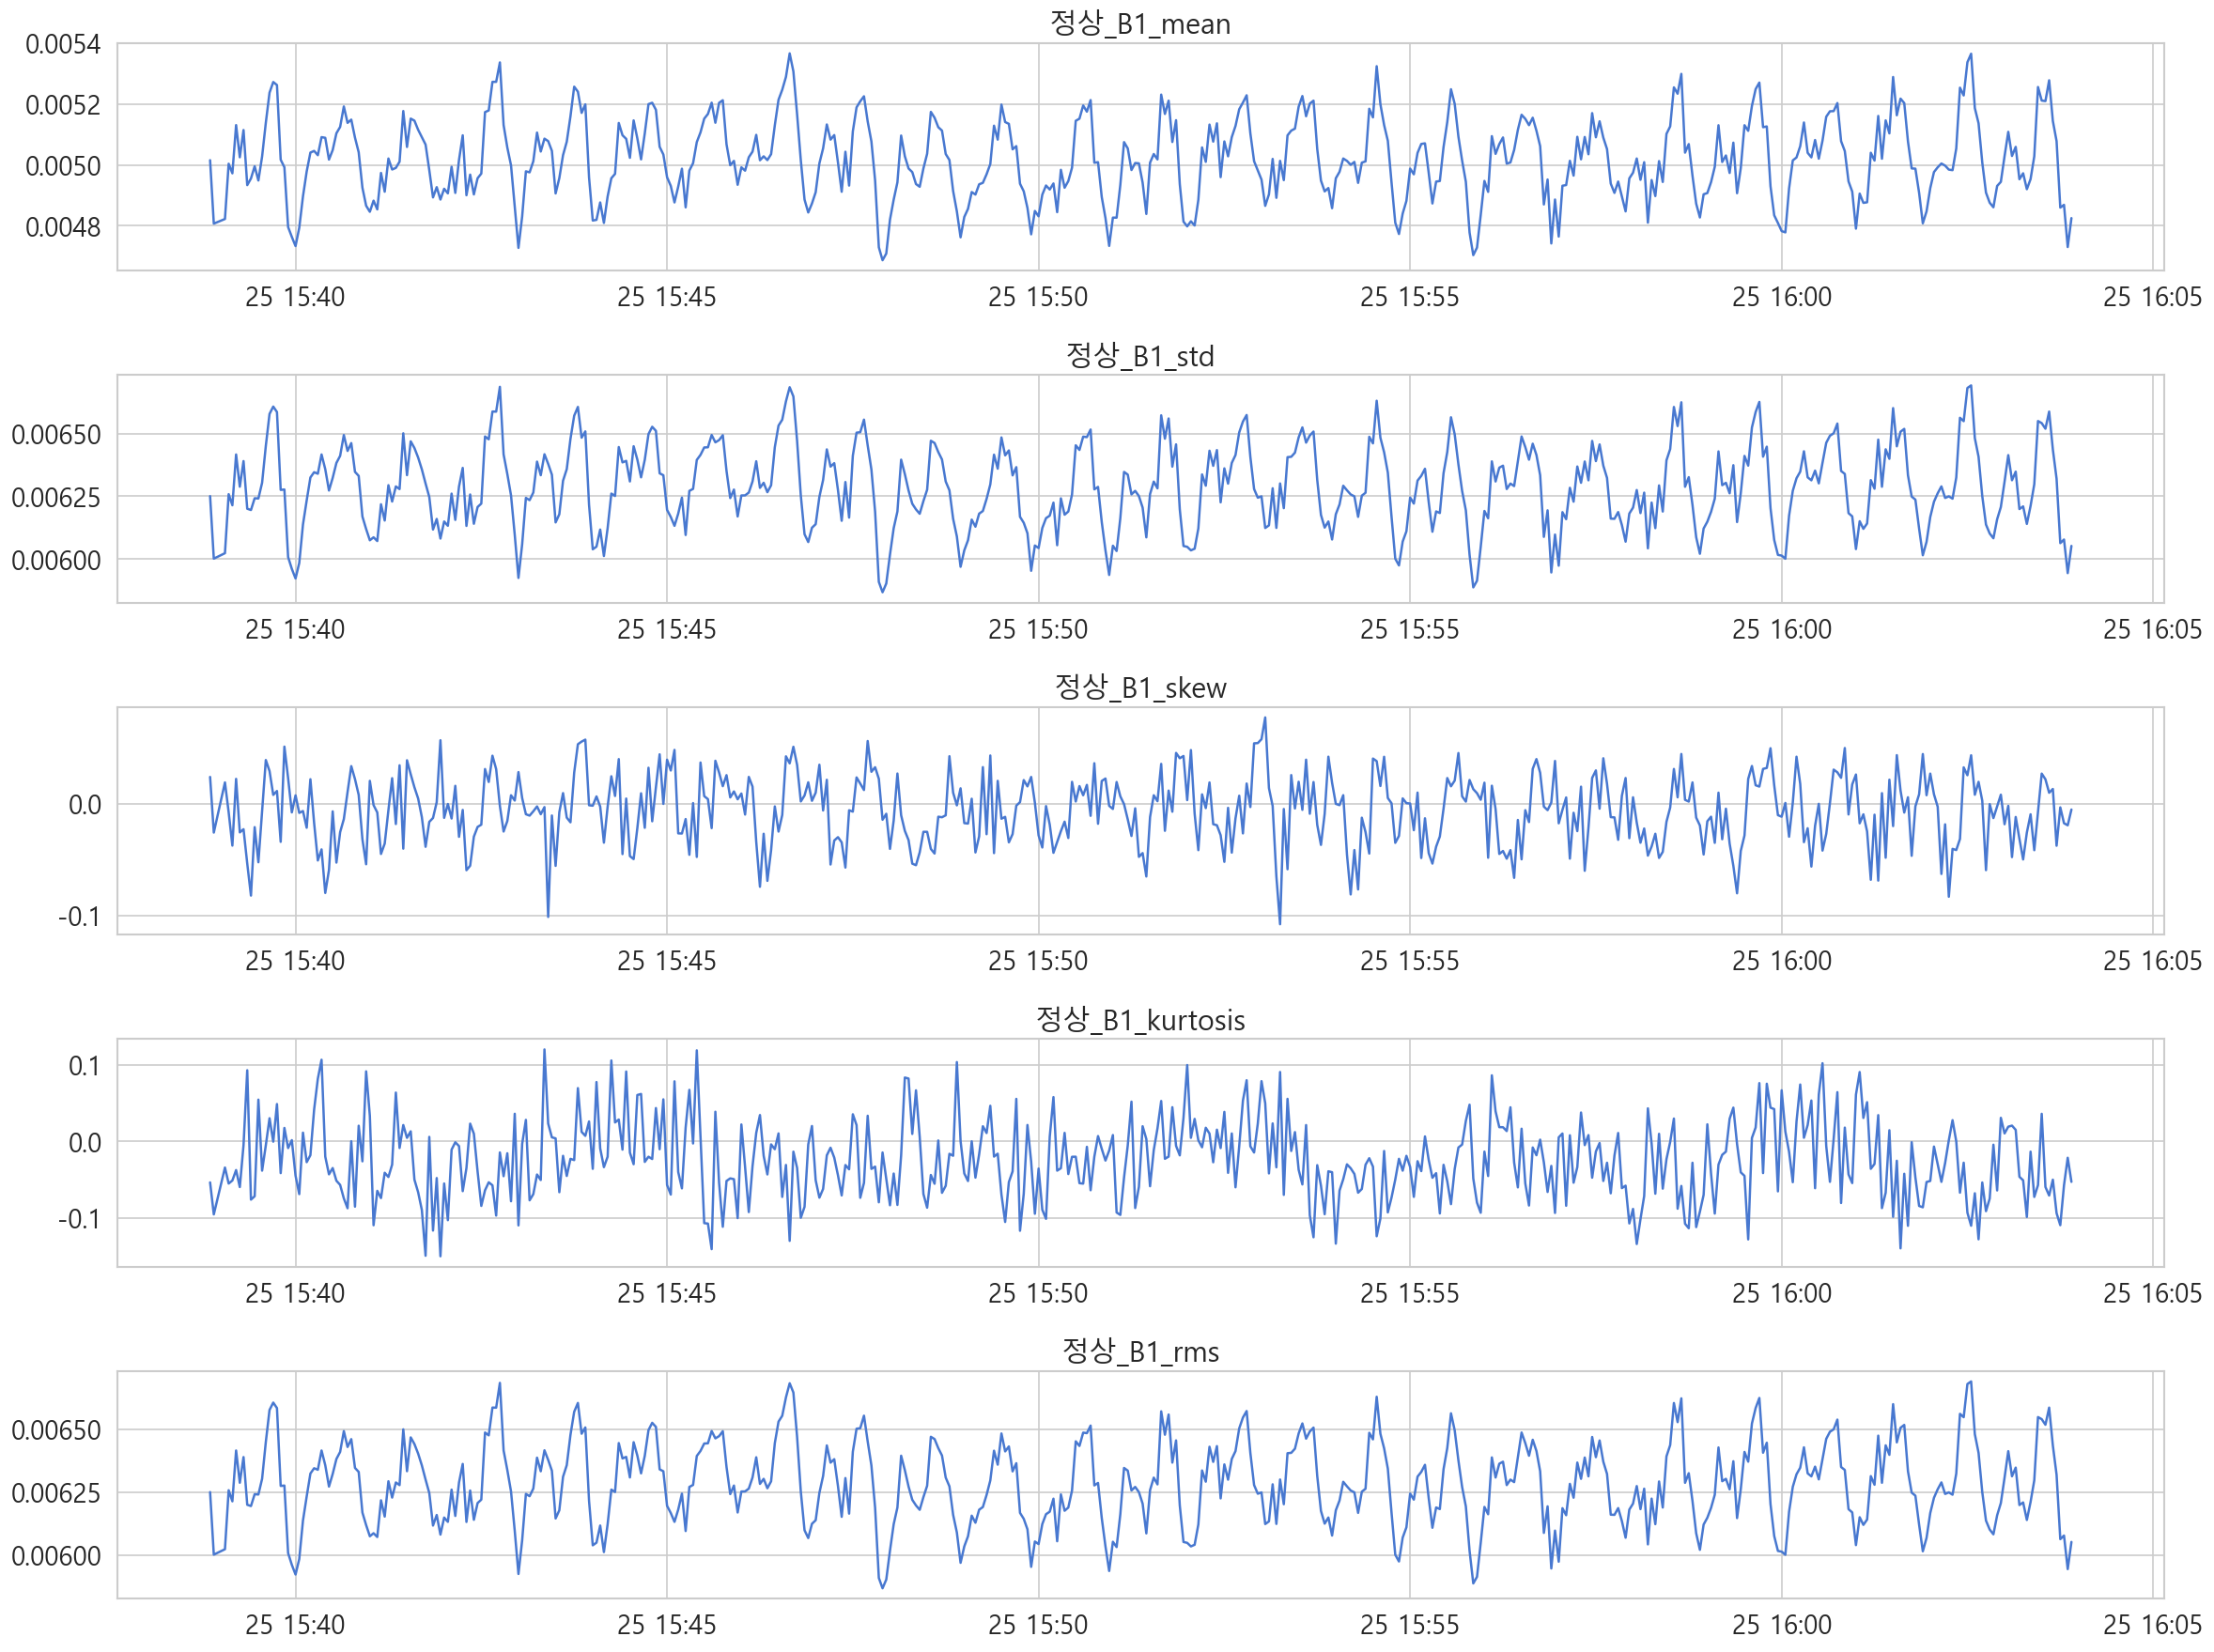

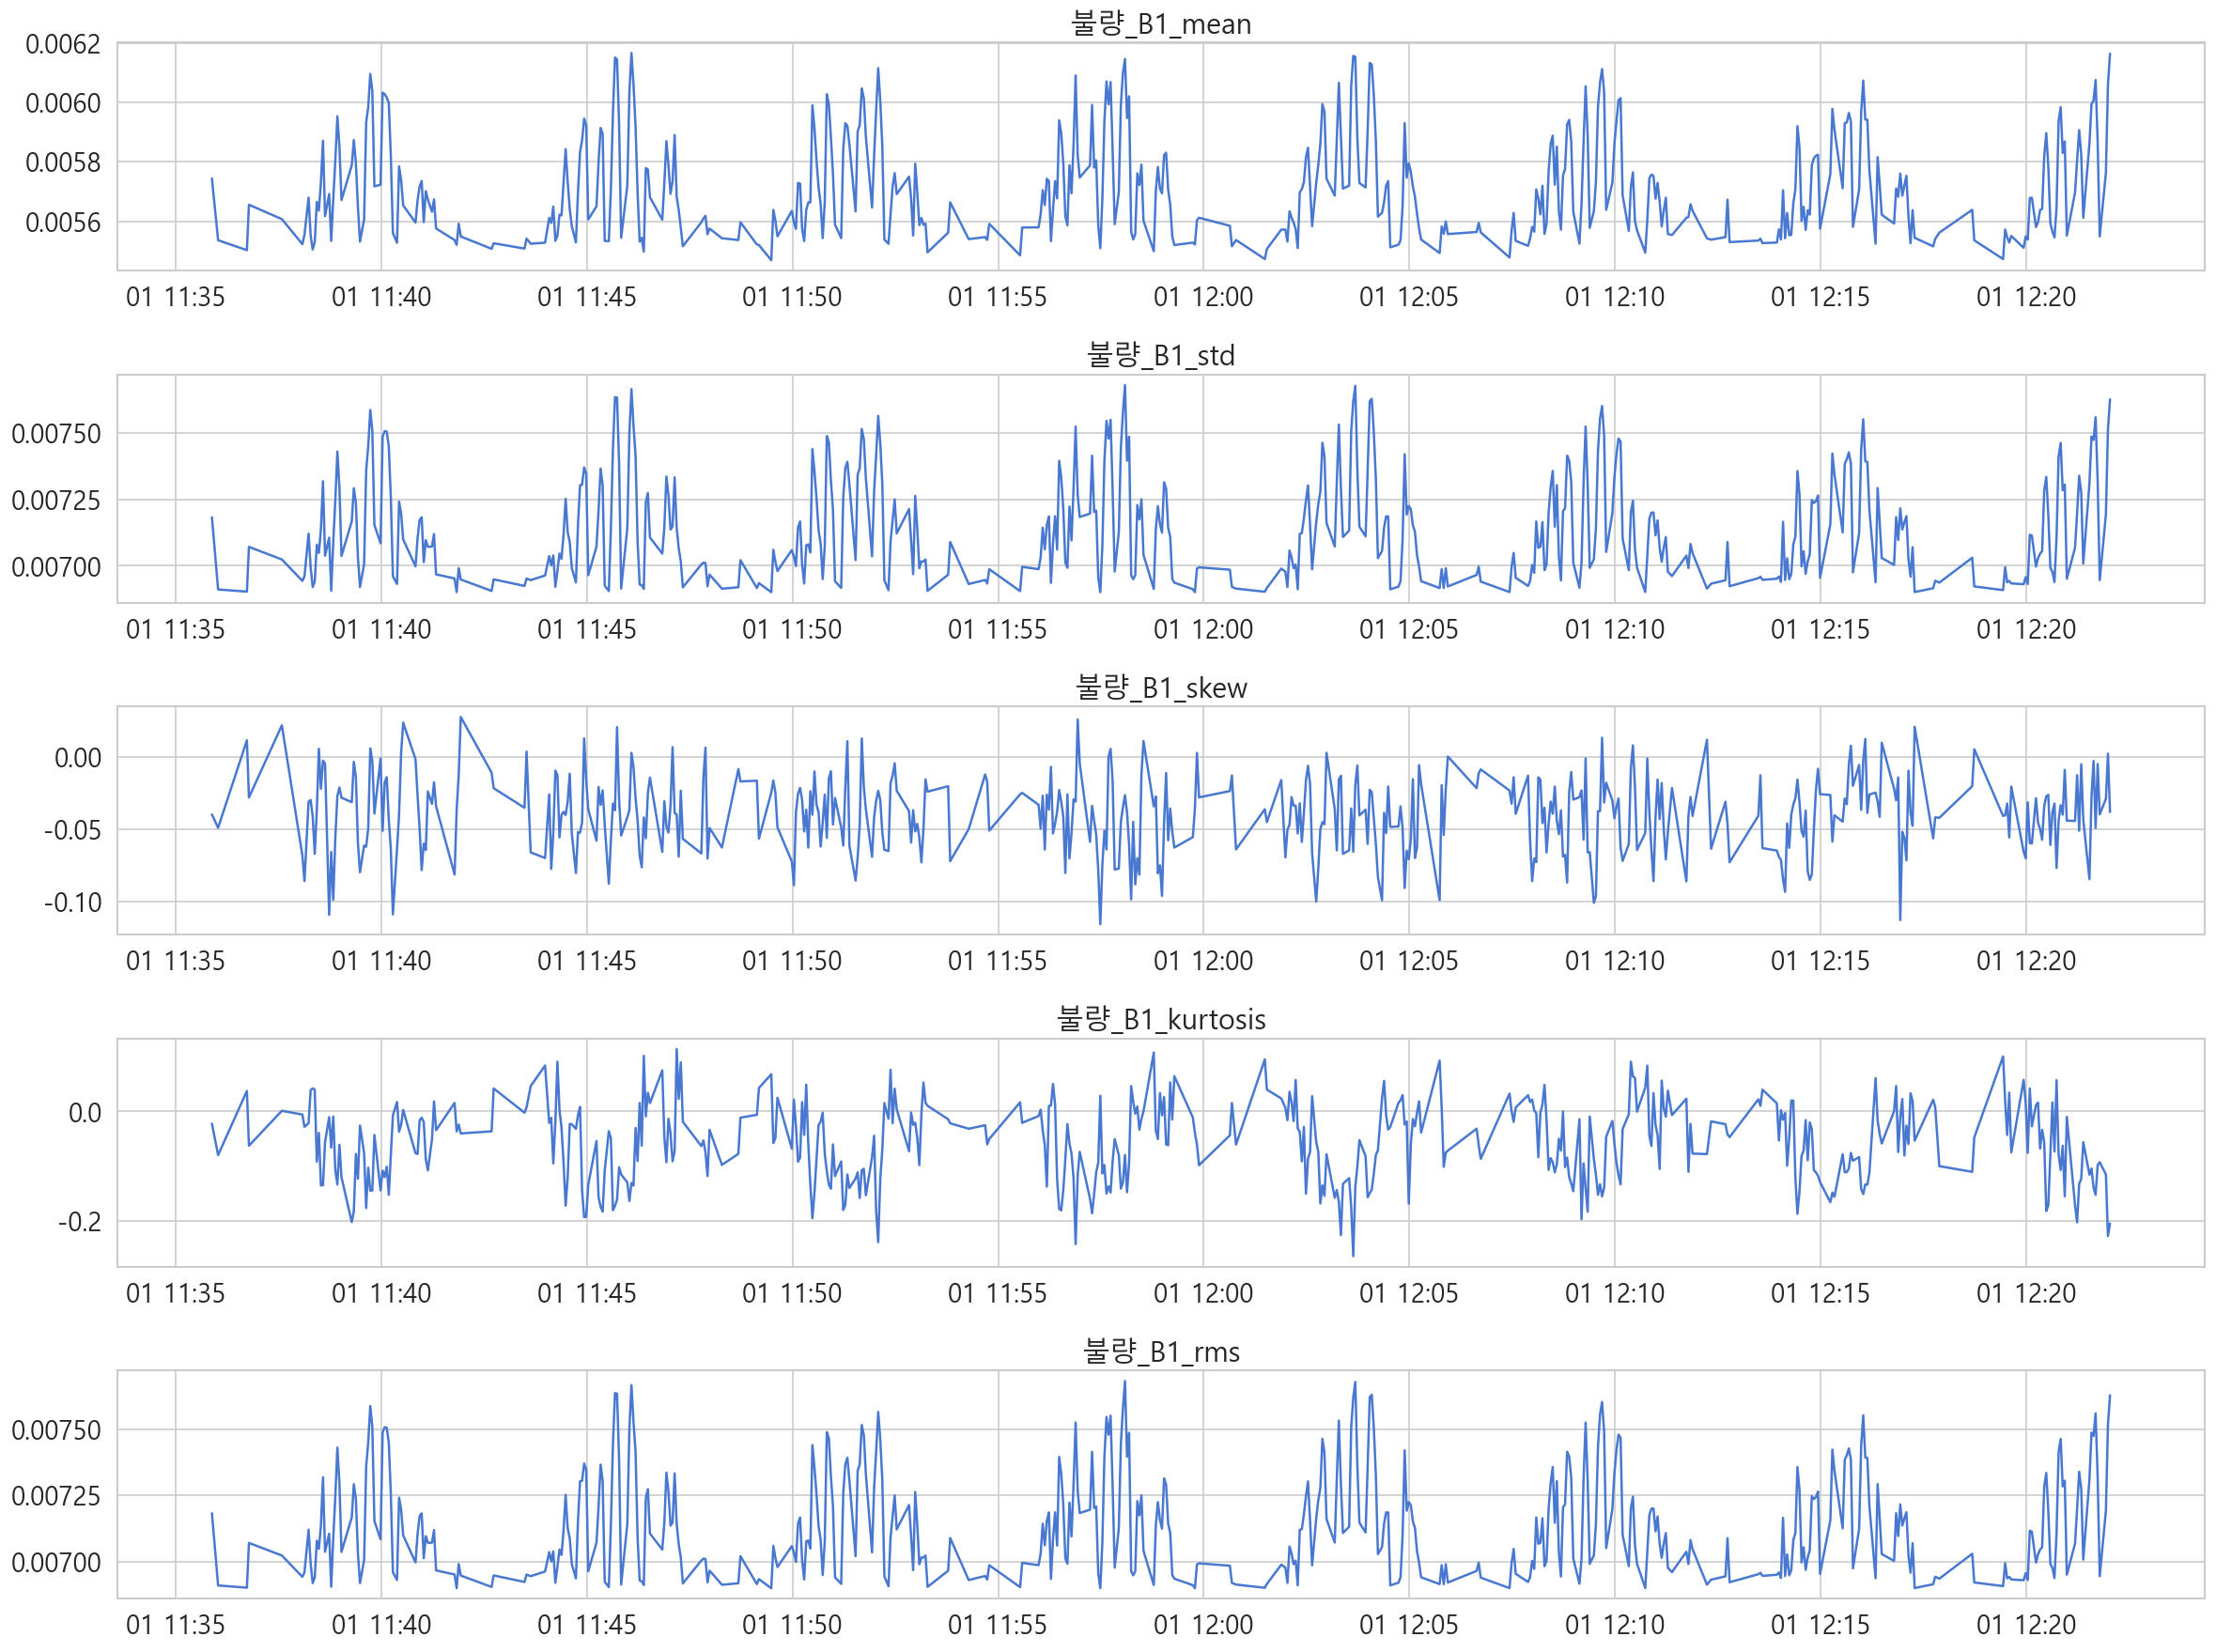

In [9]:
nsamp = 500
set_n = pd.read_csv(os.path.join(filepath,f'set_n_{nsamp}.csv'))
set_f = pd.read_csv(os.path.join(filepath,f'set_f_{nsamp}.csv'))
plot_features(set_n, ['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis','B1_rms'], "정상")
plot_features(set_f, ['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis','B1_rms'], "불량")

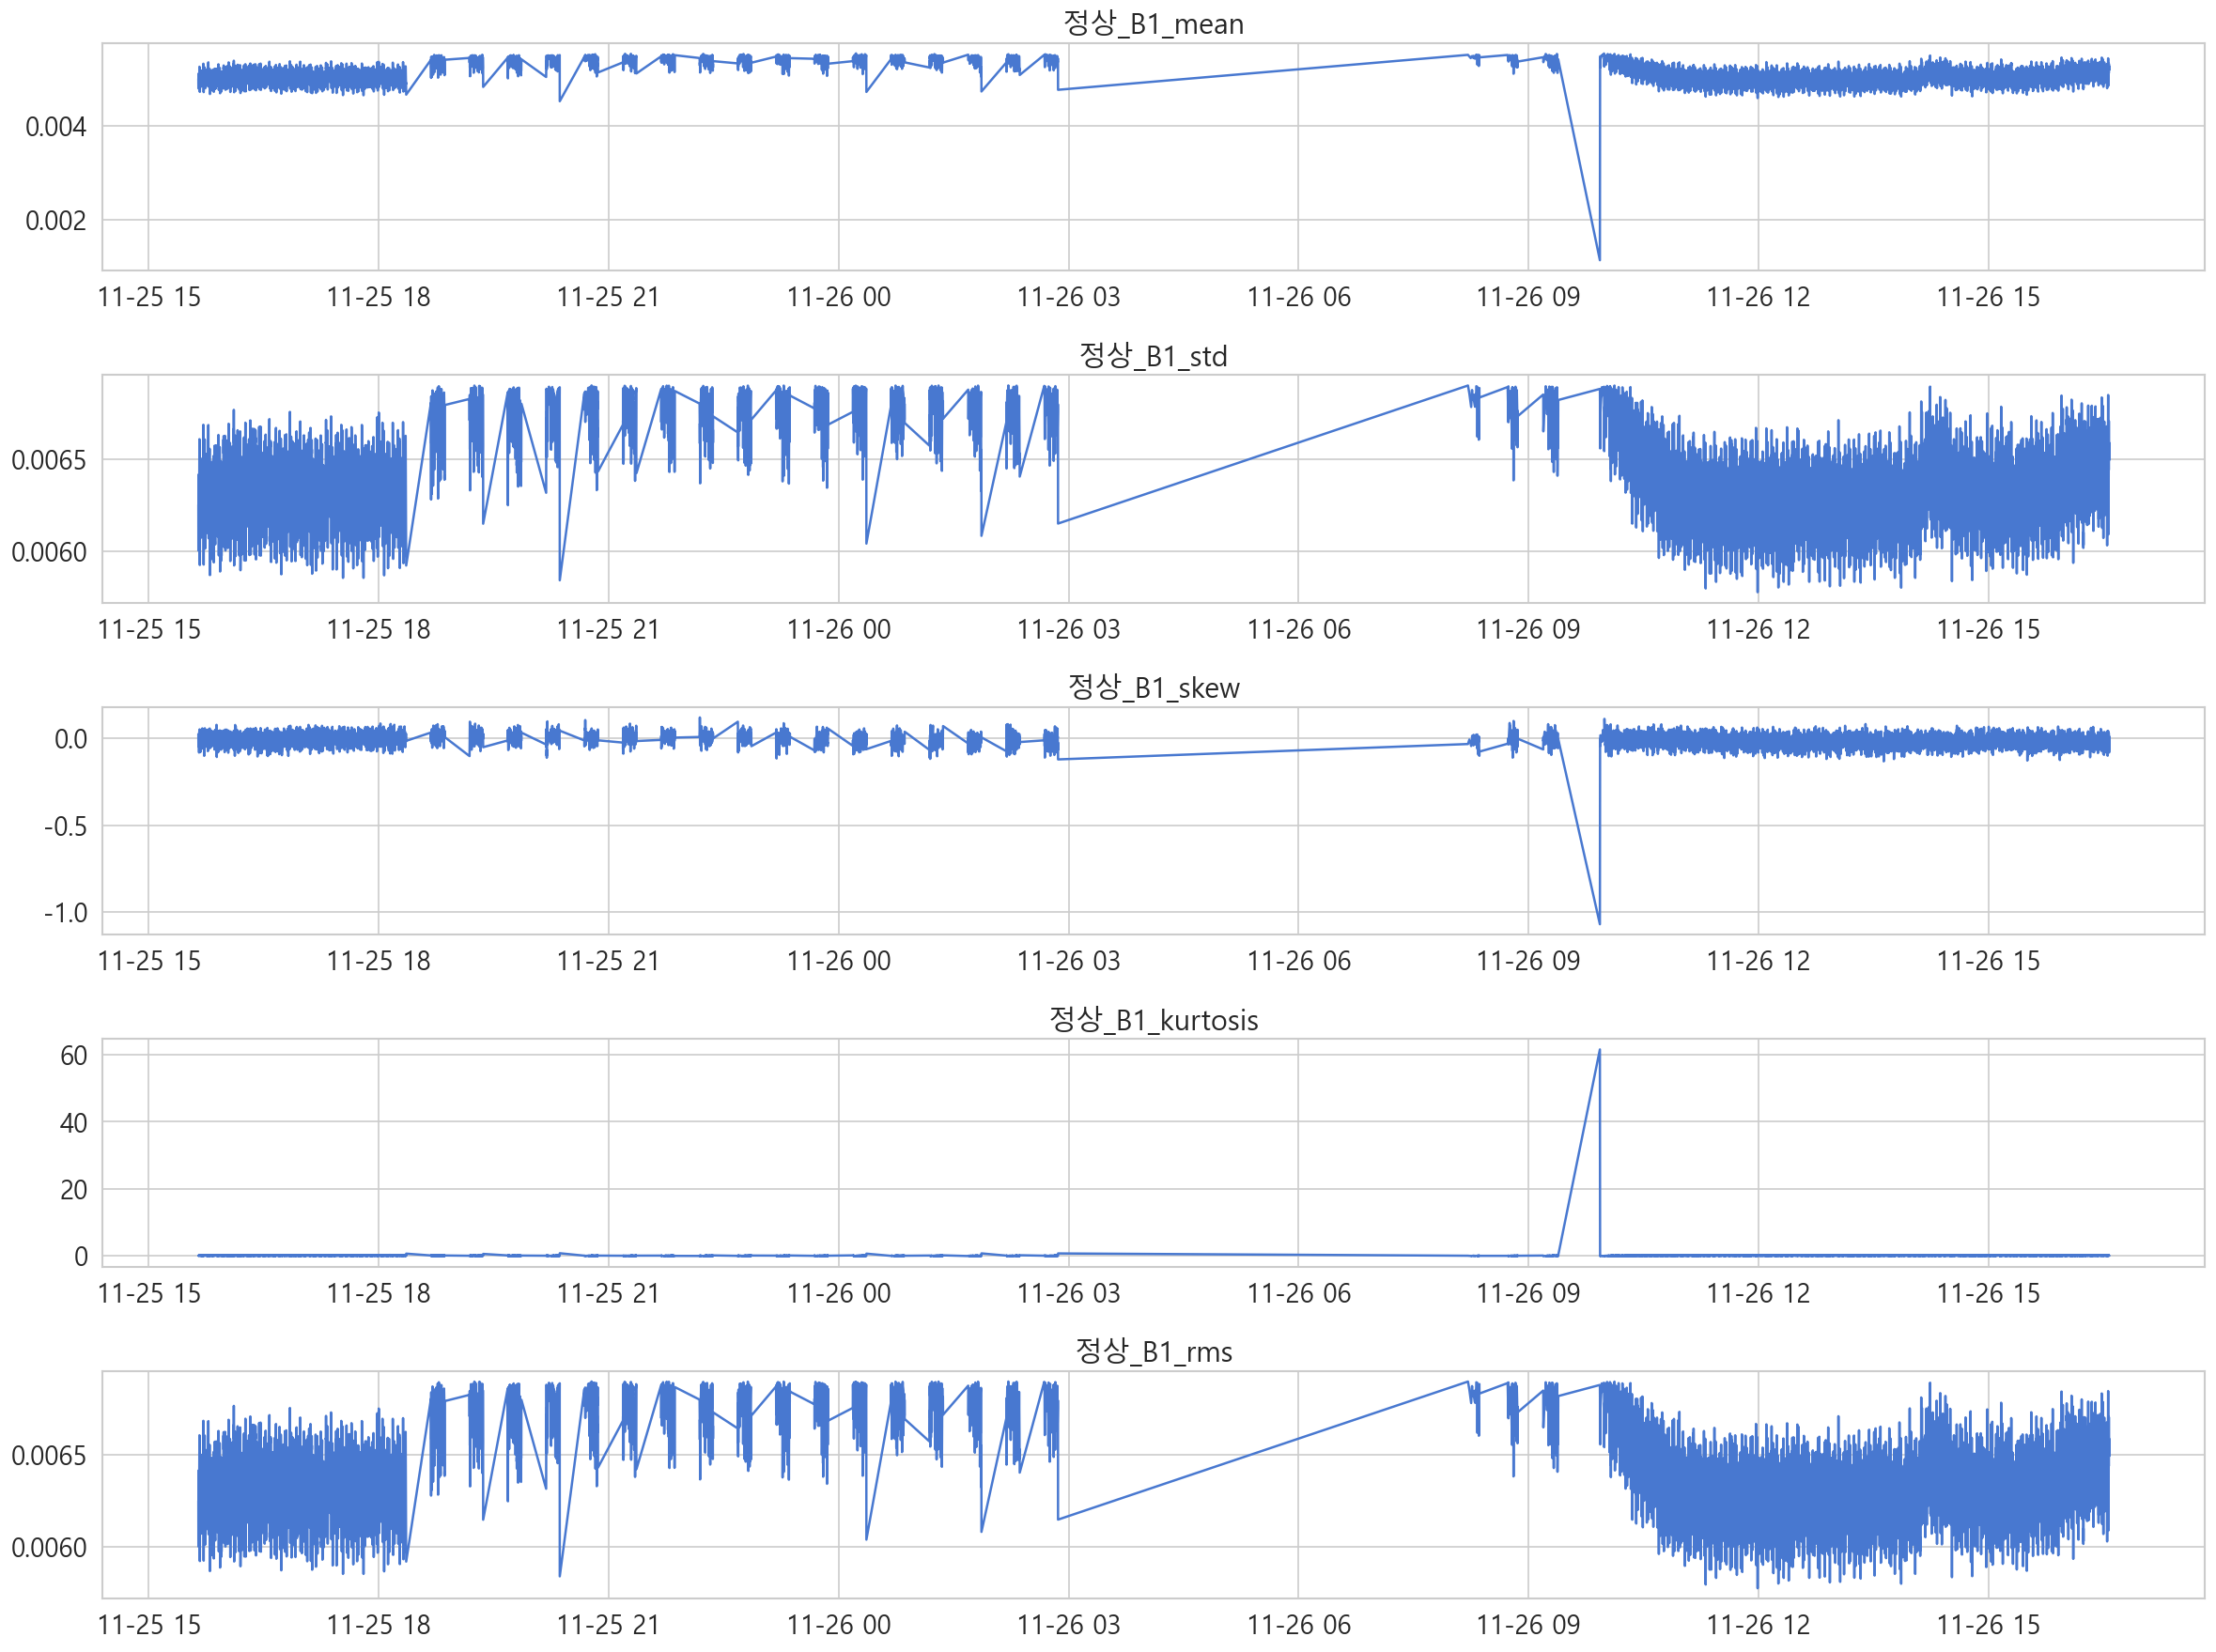

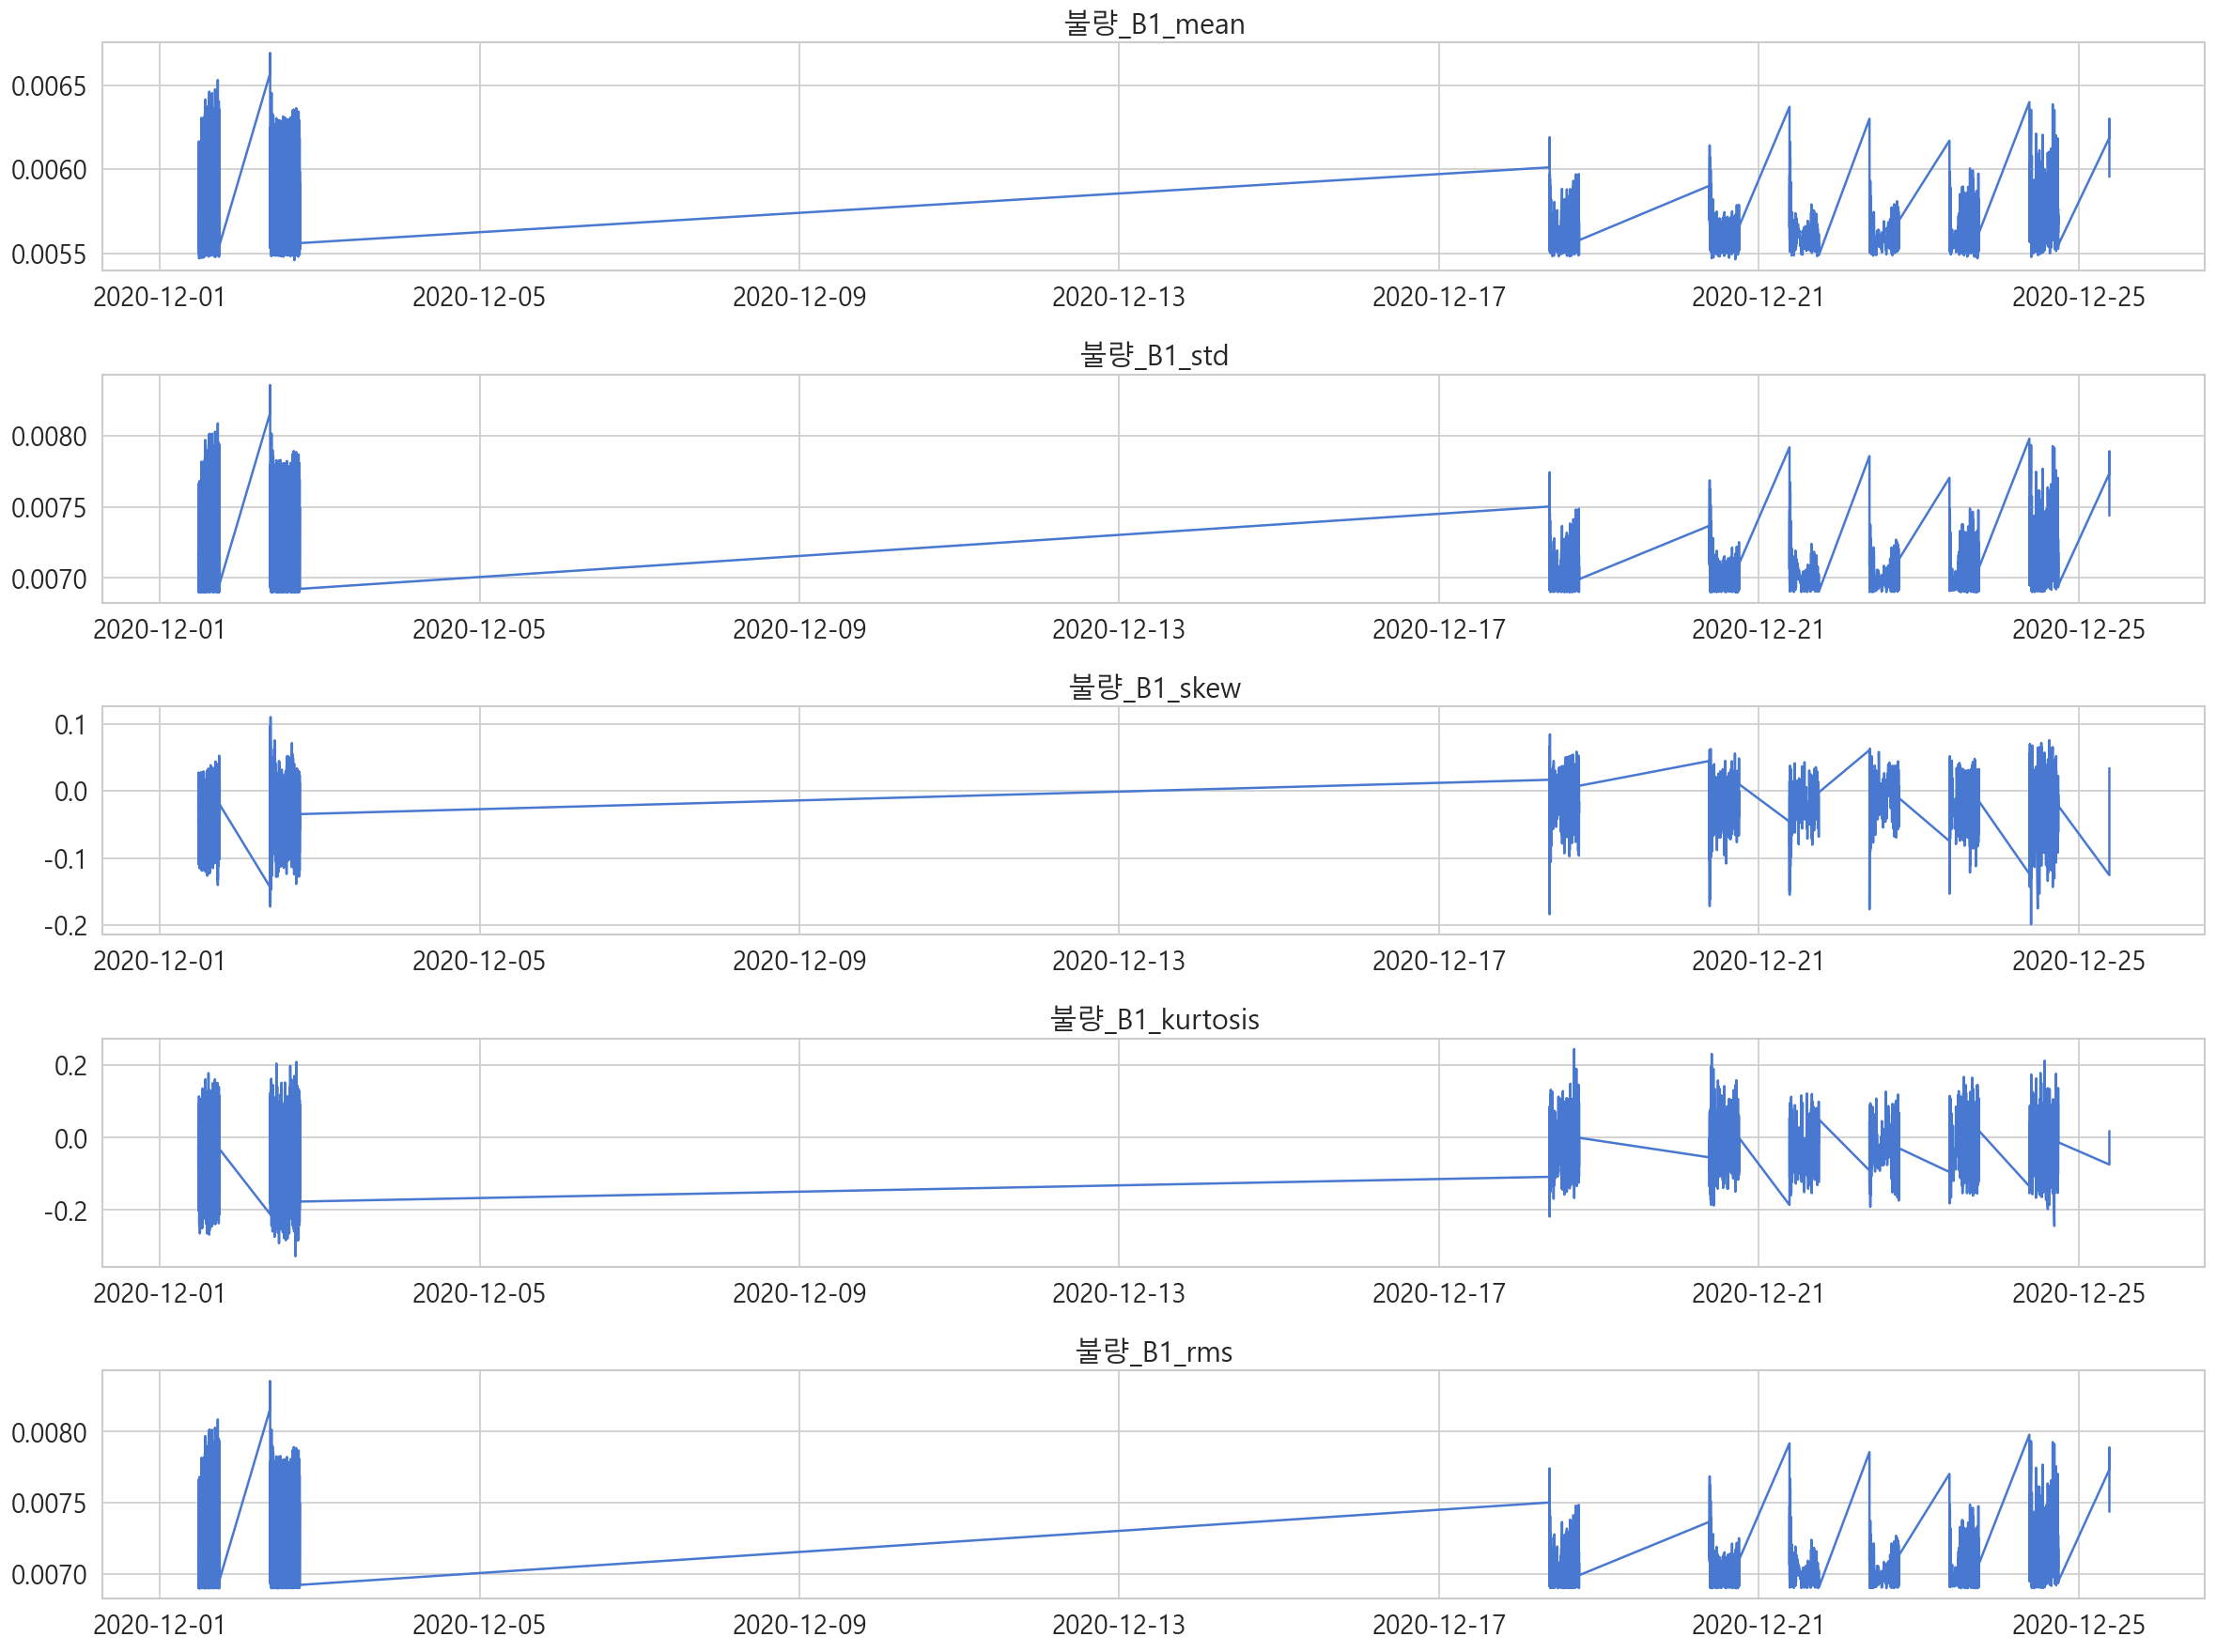

In [10]:
set_n = pd.read_csv(os.path.join(filepath,f'set_n_all.csv'))
set_f = pd.read_csv(os.path.join(filepath,f'set_f_all.csv'))
plot_features(set_n, ['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis','B1_rms'], "정상")
plot_features(set_f, ['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis','B1_rms'], "불량")

# Date Merge

## 전체 데이터 merge

In [7]:
# path = filepath_n
# df_normal = pd.DataFrame()
# for idx in tqdm(range(len(path))):
#     time = pd.to_datetime(' '.join(path[idx].split('_')[-3:-1]))
#     data = pd.read_csv(path[idx], skiprows=9, usecols=[0,1], names = ['time', 'value'])
#     st = str(time) + ':' + str(data.time[0]).split(".")[1]
#     dt1 = pd.to_datetime(st, format="%Y-%m-%d %H:%M:%S:%f")
#     ls = [dt1]
#     for i in range(data.shape[0]-1):
#         dt1 += datetime.timedelta(milliseconds=0.25)
#         ls.append(dt1)
#     data.loc[:, 'time'] = ls
#     df_normal = pd.concat([df_normal, data],ignore_index=True)
    
#     # print
#     if idx in list(range(5))+list(range(len(path)-5,len(path))):
#         print(f"time: {str(ls[0].time())} ~ {str(ls[-1].time())}")
#         print(f"-----> {df_normal.shape}")
# df_normal.to_csv(os.path.join(filepath,f'df_normal_all.csv'), index=False)

In [12]:
# path = filepath_f
# df_failure = pd.DataFrame()
# for idx in tqdm(range(len(path))):
#     time = pd.to_datetime(' '.join(path[idx].split('_')[-3:-1]))
#     data = pd.read_csv(path[idx], skiprows=9, usecols=[0,1], names = ['time', 'value'])
#     st = str(time) + ':' + str(data.time[0]).split(".")[1]
#     dt1 = pd.to_datetime(st, format="%Y-%m-%d %H:%M:%S:%f")
#     ls = [dt1]
#     for i in range(data.shape[0]-1):
#         dt1 += datetime.timedelta(milliseconds=0.25)
#         ls.append(dt1)
#     data.loc[:, 'time'] = ls
#     df_failure = pd.concat([df_failure, data],ignore_index=True)
    
#     # print
#     if idx in list(range(5))+list(range(len(path)-5,len(path))):
#         print(f"time: {str(ls[0].time())} ~ {str(ls[-1].time())}")
#         print(f"-----> {df_failure.shape}")
# df_failure.to_csv(os.path.join(filepath,f'df_failure_all.csv'), index=False)

In [13]:
nsamp = 500
df_normal_ = pd.read_csv(os.path.join(filepath,f'df_normal_{nsamp}.csv'))
df_failure_ = pd.read_csv(os.path.join(filepath,f'df_failure_{nsamp}.csv'))
df_normal_.shape, df_failure_.shape

((2550000, 2), (6000000, 2))

In [6]:
nsamp = 5000
df_normal_ = pd.read_csv(os.path.join(filepath,f'df_normal_{nsamp}.csv'))
df_failure_ = pd.read_csv(os.path.join(filepath,f'df_failure_{nsamp}.csv'))
df_normal_.shape, df_failure_.shape

((60000000, 2), (60000000, 2))

### 5초 train, 1초 test
- train set: 2020-11-25 15:38:51 ~ 2020-11-25 15:38:56.999750
- test set: 2020-12-01 11:35:53 ~ 2020-12-01 11:35:55.999750

In [9]:
df_normal = deepcopy(df_normal_)
df_normal.index = pd.to_datetime(df_normal.time)
df_normal = df_normal.drop('time', axis=1)
df_small_noise = df_normal[:df_normal.index[0]+datetime.timedelta(hours=4)]
print(df_small_noise.index)

DatetimeIndex([       '2020-11-25 15:38:51', '2020-11-25 15:38:51.000250',
               '2020-11-25 15:38:51.000500', '2020-11-25 15:38:51.000750',
               '2020-11-25 15:38:51.001000', '2020-11-25 15:38:51.001250',
               '2020-11-25 15:38:51.001500', '2020-11-25 15:38:51.001750',
               '2020-11-25 15:38:51.002000', '2020-11-25 15:38:51.002250',
               ...
               '2020-11-25 19:21:47.997500', '2020-11-25 19:21:47.997750',
               '2020-11-25 19:21:47.998000', '2020-11-25 19:21:47.998250',
               '2020-11-25 19:21:47.998500', '2020-11-25 19:21:47.998750',
               '2020-11-25 19:21:47.999000', '2020-11-25 19:21:47.999250',
               '2020-11-25 19:21:47.999500', '2020-11-25 19:21:47.999750'],
              dtype='datetime64[ns]', name='time', length=43428000, freq=None)


(20001, 1)
DatetimeIndex([       '2020-11-25 15:38:51', '2020-11-25 15:38:51.000250',
               '2020-11-25 15:38:51.000500', '2020-11-25 15:38:51.000750',
               '2020-11-25 15:38:51.001000', '2020-11-25 15:38:51.001250',
               '2020-11-25 15:38:51.001500', '2020-11-25 15:38:51.001750',
               '2020-11-25 15:38:51.002000', '2020-11-25 15:38:51.002250',
               ...
               '2020-11-25 15:38:55.997750', '2020-11-25 15:38:55.998000',
               '2020-11-25 15:38:55.998250', '2020-11-25 15:38:55.998500',
               '2020-11-25 15:38:55.998750', '2020-11-25 15:38:55.999000',
               '2020-11-25 15:38:55.999250', '2020-11-25 15:38:55.999500',
               '2020-11-25 15:38:55.999750',        '2020-11-25 15:38:56'],
              dtype='datetime64[ns]', name='time', length=20001, freq=None)


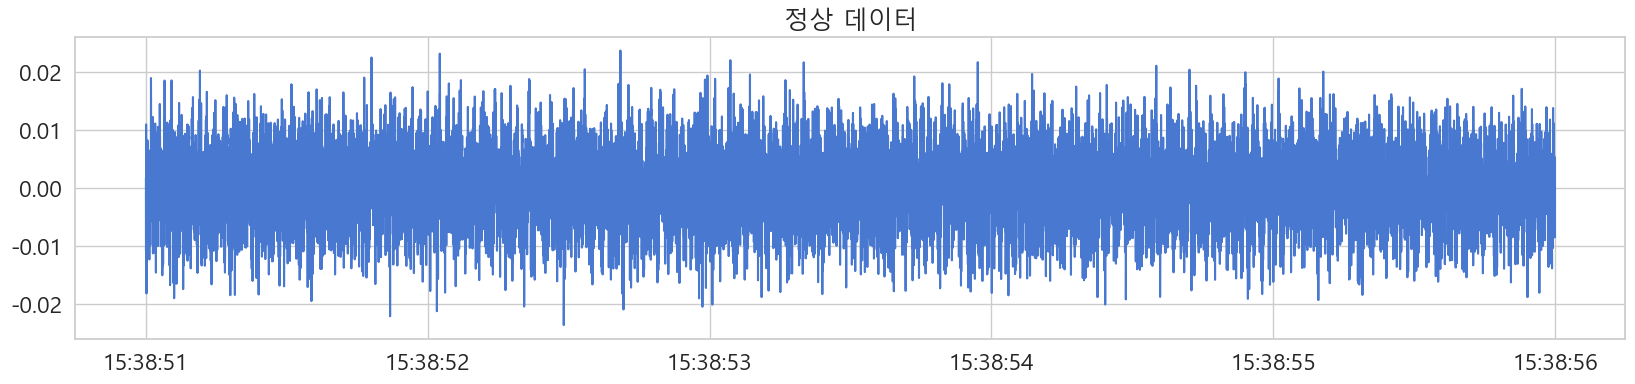

(4000, 1)
DatetimeIndex([       '2020-12-01 11:35:53', '2020-12-01 11:35:53.000250',
               '2020-12-01 11:35:53.000500', '2020-12-01 11:35:53.000750',
               '2020-12-01 11:35:53.001000', '2020-12-01 11:35:53.001250',
               '2020-12-01 11:35:53.001500', '2020-12-01 11:35:53.001750',
               '2020-12-01 11:35:53.002000', '2020-12-01 11:35:53.002250',
               ...
               '2020-12-01 11:35:53.997500', '2020-12-01 11:35:53.997750',
               '2020-12-01 11:35:53.998000', '2020-12-01 11:35:53.998250',
               '2020-12-01 11:35:53.998500', '2020-12-01 11:35:53.998750',
               '2020-12-01 11:35:53.999000', '2020-12-01 11:35:53.999250',
               '2020-12-01 11:35:53.999500', '2020-12-01 11:35:53.999750'],
              dtype='datetime64[ns]', name='time', length=4000, freq=None)


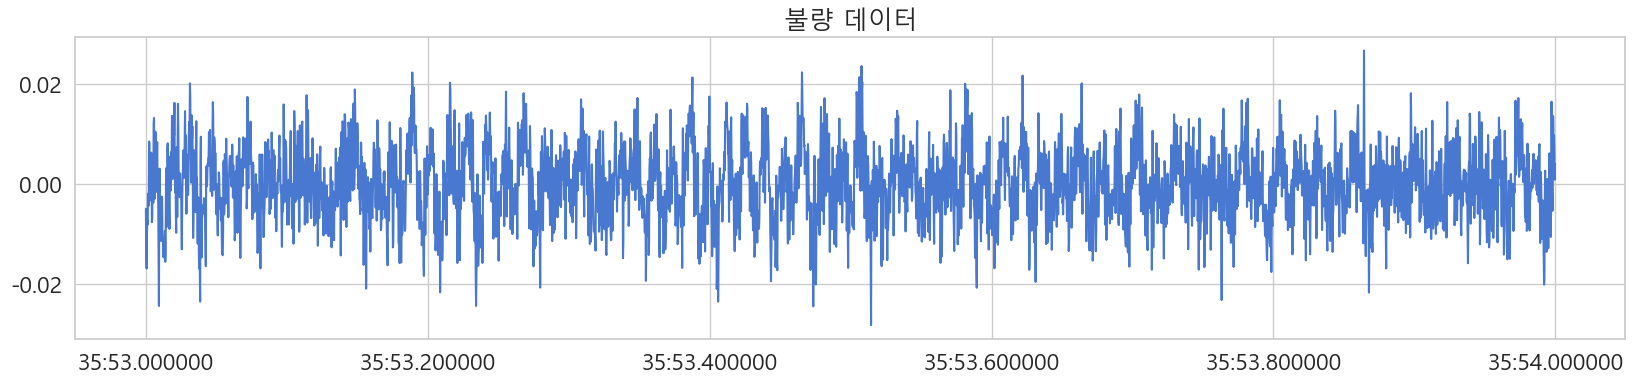

In [38]:
df_normal = deepcopy(df_normal_)
df_failure = deepcopy(df_failure_)

df_normal.index = pd.to_datetime(df_normal.time)
df_normal = df_normal.drop('time', axis=1)
df_small_noise = df_normal[:df_normal.index[0]+datetime.timedelta(seconds=5)]
print(df_small_noise.shape)
print(df_small_noise.index)

fig, ax = plt.subplots(figsize=(20,4), dpi=100)
plt.plot(df_small_noise.index, df_small_noise.value)
plt.title("정상 데이터")
plt.show()


df_failure.index = pd.to_datetime(df_failure.time)
df_failure = df_failure.drop('time', axis=1)
df_daily_jumpsup = df_failure[:df_failure.index[0]+datetime.timedelta(seconds=1)].iloc[:-1,]
print(df_daily_jumpsup.shape)
print(df_daily_jumpsup.index)

fig, ax = plt.subplots(figsize=(20,4), dpi=100)
plt.plot(df_daily_jumpsup.index, df_daily_jumpsup.value)
plt.title("불량 데이터")
plt.show()

In [21]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 20001


In [22]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (19714, 288, 1)


In [23]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [24]:
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/10
139/139 [==============================] - 5s 31ms/step - loss: 0.2958 - val_loss: 0.0503
Epoch 2/10
139/139 [==============================] - 4s 28ms/step - loss: 0.1040 - val_loss: 0.0349
Epoch 3/10
139/139 [==============================] - 4s 28ms/step - loss: 0.0806 - val_loss: 0.0299
Epoch 4/10
139/139 [==============================] - 4s 30ms/step - loss: 0.0625 - val_loss: 0.0405
Epoch 5/10
139/139 [==============================] - 4s 32ms/step - loss: 0.0512 - val_loss: 0.0441
Epoch 6/10
139/139 [==============================] - 5s 33ms/step - loss: 0.0450 - val_loss: 0.0432
Epoch 7/10
139/139 [==============================] - 4s 32ms/step - loss: 0.0407 - val_loss: 0.0444
Epoch 8/10
139/139 [==============================] - 5s 36ms/step - loss: 0.0377 - val_loss: 0.0441


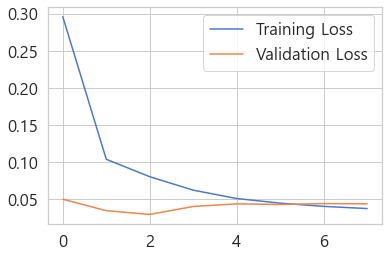

In [25]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

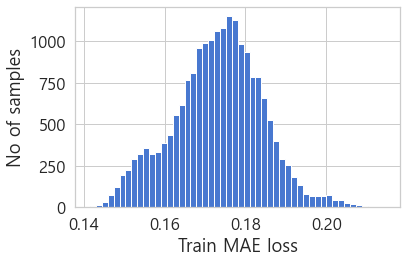

Reconstruction error threshold:  0.2146611875374923


In [37]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.tight_layout()
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

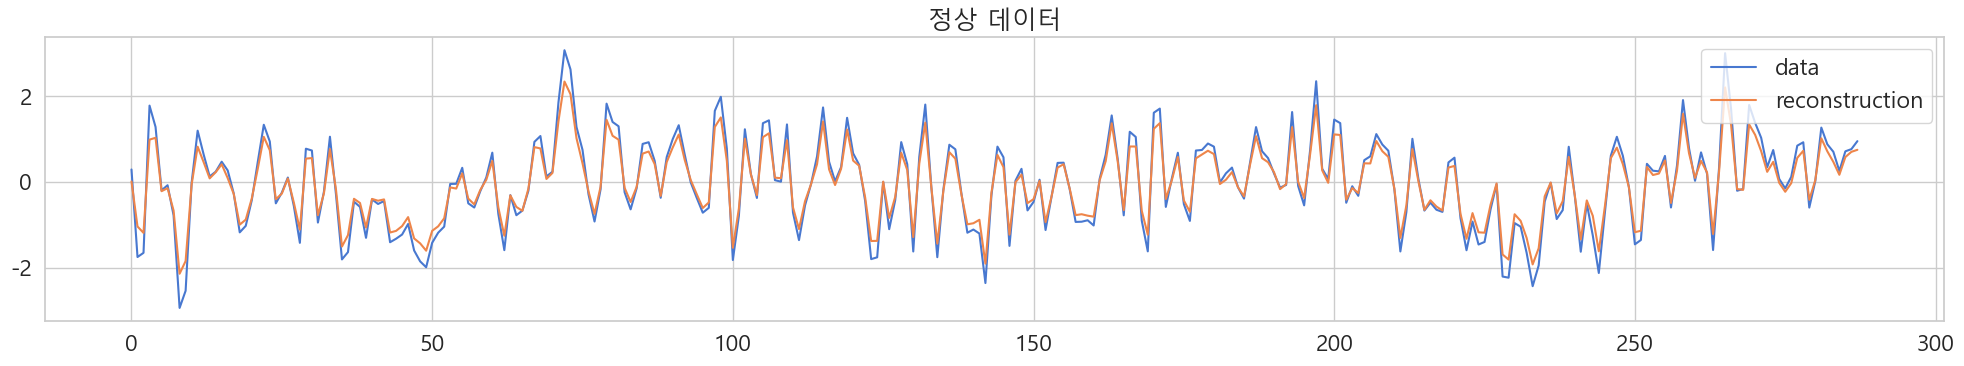

In [36]:
fig, ax = plt.subplots(figsize=(20,4), dpi=100)
plt.plot(x_train[0], label="data")
plt.plot(x_train_pred[0], label="reconstruction")
plt.title("정상 데이터")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

Test input shape:  (3713, 288, 1)


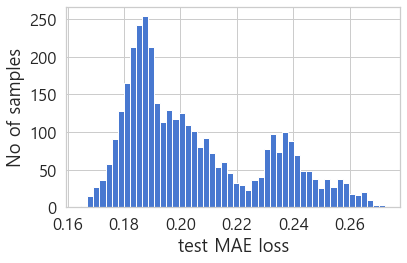

Number of anomaly samples:  1130
Indices of anomaly samples:  (array([   0,    1,    2, ..., 2281, 2282, 2283], dtype=int64),)


In [35]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.tight_layout()
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [31]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

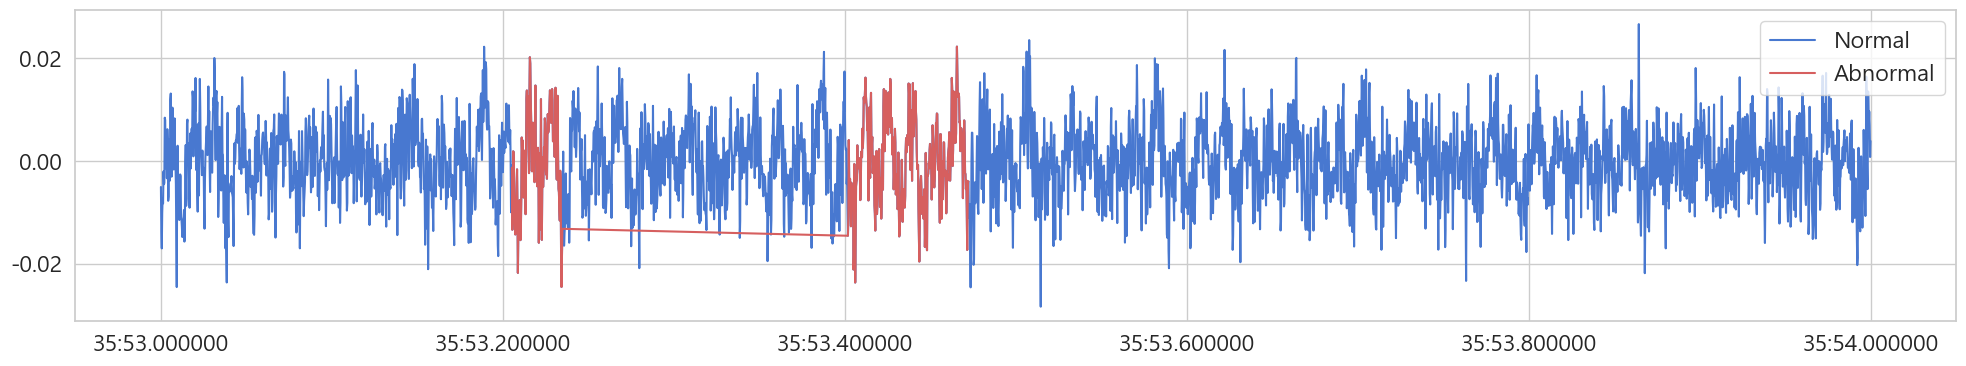

In [34]:
fig, ax = plt.subplots(figsize=(20,4), dpi=100)
plt.plot(df_daily_jumpsup.index, df_daily_jumpsup.value, label="Normal")
plt.plot(df_subset.index, df_subset.value, color="r",label="Abnormal")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()